In [1]:
# import all libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

In [62]:
# read csv file and store it into a dataframe
df = pd.read_csv("2. train_sales_forecast.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.IsHoliday = df.IsHoliday.astype(int)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,25037.08,0
1,1,1,2010-02-12,46247.44,1
2,1,1,2010-02-19,41783.43,0
3,1,1,2010-02-26,19491.18,0
4,1,1,2010-03-05,21926.49,0


In [63]:
def impute_missing_rows(df):
    """
    This function imputes missing rows to the dataframe to make it evenly spaned.

    Parameters:
    df: The pandas DataFrame object

    Returns:
    df: The pandas DataFrame object after imputation
    """
    print(f"Shape of dataframe before imputation: {df.shape}")
    # get minimum and maximum dates from the entire dataframe
    end_date = df.Date.max()
    start_date = df.Date.min()
    # get all the unique stores in the dataframe
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        # get all the departments from that store
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            # start_date = df_store_dept.Date.min()
            current_date = start_date
            while current_date <= end_date:
                # if a date is not present, impute it with Zero sales
                if current_date not in df_store_dept.Date.values:
                    # print([store_no, dept_no, current_date])
                    try:
                        # get the holiday information of the missing date from the entire df
                        is_holiday = df[df.Date == current_date]['IsHoliday'].values[0]
                    except:
                        print("Date not present in the entire dataframe, considering False")
                        is_holiday = False
                    df.loc[len(df)] = [store_no, dept_no, current_date, 0, is_holiday]
                current_date += timedelta(days=7)
    print(f"Shape of dataframe after imputation: {df.shape}")
    return df

In [64]:
def preprocess_dataframe(df):
    """
    This function preprocess the data before training.

    Parameters:
    df: The pandas DataFrame object

    Returns:
    df: The pandas DataFrame object after preprocessing
    """
    # impute missing rows in the dataframe
    df = impute_missing_rows(df)
    df.IsHoliday = df.IsHoliday.astype(int)
    return df

In [65]:
df = preprocess_dataframe(df)

Shape of dataframe before imputation: (84056, 5)
Shape of dataframe after imputation: (90909, 5)


In [66]:
def filter_dataframe(df, store, dept):
    """
    This function filters dataframe based on store no and department.

    Parameters:
    df: The pandas DataFrame object
    store: Store number
    dept: Deparrtment number

    Returns:
    df: The pandas DataFrame object after filtering based on store and dept
    """
    df = df[(df['Store'] == store) & (df['Dept'] == dept)]
    return df

In [67]:
def generate_lag_features(df, lag, column_name):
    df[f"{column_name}_lag{lag}"] = df[column_name].shift(lag)
    return df

In [68]:
lags_list = [1, 2, 3, 4]
column_list = ['Weekly_Sales']
def generate_lag_df(df, lags_list, column_list):
    df_lag_feature = pd.DataFrame()
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        # get all the departments from that store
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            df_store_dept = df_store_dept.sort_values(by='Date')
            for lag in lags_list:
                for column_name in column_list:
                    df_store_dept = generate_lag_features(df_store_dept, lag, column_name)
            df_lag_feature  = pd.concat([df_lag_feature, df_store_dept], ignore_index=False)
    return df_lag_feature

In [69]:
df = generate_lag_df(df, lags_list, column_list)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Weekly_Sales_lag1,Weekly_Sales_lag2,Weekly_Sales_lag3,Weekly_Sales_lag4
0,1,1,2010-02-05,25037.08,0,NaN,NaN,NaN,NaN
1,1,1,2010-02-12,46247.44,1,25037.08,NaN,NaN,NaN
2,1,1,2010-02-19,41783.43,0,46247.44,25037.08,NaN,NaN
3,1,1,2010-02-26,19491.18,0,41783.43,46247.44,25037.08,NaN
4,1,1,2010-03-05,21926.49,0,19491.18,41783.43,46247.44,25037.08


In [70]:
def generate_previous_rolling_mean(df, column_name, window_size):
    df[f'{column_name}_prev_rolling_mean_{window_size}_week'] = df[column_name].shift(1).rolling(window_size).mean()
    return df

In [71]:
def generate_previous_rolling_mean_df(df, rolling_window_list, column_list):
    df_rolling_mean_feature = pd.DataFrame()
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        # get all the departments from that store
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            df_store_dept = df_store_dept.sort_values(by='Date')
            for rolling_window in rolling_window_list:
                for column_name in column_list:
                    df_store_dept = generate_previous_rolling_mean(df_store_dept, column_name, rolling_window)
            df_rolling_mean_feature  = pd.concat([df_rolling_mean_feature, df_store_dept], ignore_index=False)
    return df_rolling_mean_feature

In [72]:
rolling_window_list = [2, 4]
column_list = ['Weekly_Sales']
df = generate_previous_rolling_mean_df(df, rolling_window_list, column_list)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Weekly_Sales_lag1,Weekly_Sales_lag2,Weekly_Sales_lag3,Weekly_Sales_lag4,Weekly_Sales_prev_rolling_mean_2_week,Weekly_Sales_prev_rolling_mean_4_week
0,1,1,2010-02-05,25037.08,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2010-02-12,46247.44,1,25037.08,NaN,NaN,NaN,NaN,NaN
2,1,1,2010-02-19,41783.43,0,46247.44,25037.08,NaN,NaN,35642.260,NaN
3,1,1,2010-02-26,19491.18,0,41783.43,46247.44,25037.08,NaN,44015.435,NaN
4,1,1,2010-03-05,21926.49,0,19491.18,41783.43,46247.44,25037.08,30637.305,33139.7825


In [73]:
# drop null values that are created after shift and rolling window operation
df = df.dropna()
df.shape

(87801, 11)

#### Split Train, Validation, Test, based on time axis (Temporal Splitting)

In [74]:
# train, test, vali
df_train = df[df.Date <= pd.to_datetime("2011-10-31")].reset_index(drop=True)
df_val = df[(df.Date >= pd.to_datetime("2011-11-01")) & (df.Date <= pd.to_datetime("2012-01-31"))].reset_index(drop=True)
df_test = df[(df.Date >= pd.to_datetime("2012-02-01")) & (df.Date <= pd.to_datetime("2012-04-30"))].reset_index(drop=True)
df_train_val = df[df.Date <= pd.to_datetime("2012-01-31")].reset_index(drop=True)

df_train.shape, df_val.shape, df_test.shape, df_train_val.shape

((67599, 11), (10101, 11), (10101, 11), (77700, 11))

In [75]:
# this method computes MAPE for a dataframe based on actual and forecasted value
def mean_absolute_percentage_error(df):
    """
    Calculate the Mean Absolute Percentage Error (MAPE)

    Parameters:
    df: dataframe object

    Returns:
    float: MAPE value
    """
    df = df.dropna()
    y_true = df['Weekly_Sales']
    y_pred = df['Weekly_Sales_Predicted']
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Exclude cases where y_true is zero to avoid division by zero
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    
    if len(y_true_non_zero) == 0:
        raise ValueError("All true values are zero, MAPE cannot be computed.")
    
    return np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero))

In [88]:
from sklearn.linear_model import Ridge
def fit_ridge_regressor(X_train, y_train, alpha):
    """
    This function fits linear regressor model
    """
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    
    return model

In [79]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Weekly_Sales_lag1,Weekly_Sales_lag2,Weekly_Sales_lag3,Weekly_Sales_lag4,Weekly_Sales_prev_rolling_mean_2_week,Weekly_Sales_prev_rolling_mean_4_week
0,1,1,2010-03-05,21926.49,0,19491.18,41783.43,46247.44,25037.08,30637.305,33139.7825
1,1,1,2010-03-12,21138.44,0,21926.49,19491.18,41783.43,46247.44,20708.835,32362.1350
2,1,1,2010-03-19,22236.62,0,21138.44,21926.49,19491.18,41783.43,21532.465,26084.8850
3,1,1,2010-03-26,26347.68,0,22236.62,21138.44,21926.49,19491.18,21687.530,21198.1825
4,1,1,2010-04-02,57517.05,0,26347.68,22236.62,21138.44,21926.49,24292.150,22912.3075


In [84]:
from sklearn.preprocessing import StandardScaler
def preprocess_data_for_regression(df):
    # Drop NaN values created by shifting/rolling
    df.dropna(inplace=True)
    scaler = StandardScaler()
    # Define features and target variable
    y_train = df['Weekly_Sales']
    columns_to_drop = ['Date', 'Weekly_Sales', 'Store', 'Dept']
    X_train = df.drop(columns=columns_to_drop)
    X_train = scaler.fit_transform(X_train)
    return X_train, y_train, scaler

#### Ridge Regressor:

In [89]:
def train_ridge_regressor(df, alpha):
    """
    This function trains every series of the dataframe.
    """
    models_dict = {}
    
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            X_train, y_train, scaler = preprocess_data_for_regression(df_store_dept)
            try:
                model_fit = fit_ridge_regressor(X_train, y_train, alpha)
                models_dict[(store_no, dept_no)] = (scaler, model_fit)
            except Exception as e:
                print(f'Failed to fit Ridge Regressor model for store {store_no}, category {dept_no}: {e}')
    return models_dict

In [122]:
def get_prediction_ridge_regressor(df, models_dict):
    predicted_ridge_df = pd.DataFrame()
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            df_store_dept = df_store_dept.sort_values(by='Date')
            date_test = df_store_dept['Date']
            y_test = df_store_dept['Weekly_Sales']
            columns_to_drop = ['Date', 'Weekly_Sales', 'Store', 'Dept']
            X_test = df_store_dept.drop(columns=columns_to_drop)
            X_test = models_dict[(store_no, dept_no)][0].transform(X_test)
            y_val_pred = models_dict[(store_no, dept_no)][1].predict(X_test)
            prediction_df = pd.DataFrame({
                            'Date': date_test,
                            'Weekly_Sales': y_test,
                            'Weekly_Sales_Predicted': y_val_pred})
            prediction_df['Store'] = store_no
            prediction_df['Dept'] = dept_no
            predicted_ridge_df  = pd.concat([predicted_ridge_df, prediction_df], ignore_index=False)
    return predicted_ridge_df

In [109]:
def plot_original_and_predicted_data(df, col1='Weekly_Sales', col2='Weekly_Sales_Predicted'):
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df, x='Date', y=col1, label='Original')
    sns.lineplot(data=df, x='Date', y=col2, label='Predicted')
    
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.title('Original vs Predicted Weekly Sales Forecasts')
    plt.legend()
    plt.show()

In [111]:
import warnings
warnings.filterwarnings('ignore')

In [127]:
# training model with alpha = 1
ridge_trained_models_dict = train_ridge_regressor(df_train, alpha=1)
train_forecasted_ridge_df = get_prediction_ridge_regressor(df_train, ridge_trained_models_dict)
mape_score_ridge_train = round(mean_absolute_percentage_error(train_forecasted_ridge_df), 4)
validation_forecasted_ridge_df = get_prediction_ridge_regressor(df_val, ridge_trained_models_dict)
mape_score_ridge_validation = round(mean_absolute_percentage_error(validation_forecasted_ridge_df), 4)

print(f"Train Score for Ridge Regressor is {mape_score_ridge_train}")
print(f"Validation Score for Ridge Regressor is {mape_score_ridge_validation}")

Train Score for Ridge Regressor is 8.4389
Validation Score for Ridge Regressor is 0.3653


In [129]:
# training model with alpha = 0.1
ridge_trained_models_dict = train_ridge_regressor(df_train, alpha=0.1)
train_forecasted_ridge_df = get_prediction_ridge_regressor(df_train, ridge_trained_models_dict)
mape_score_ridge_train = round(mean_absolute_percentage_error(train_forecasted_ridge_df), 4)
validation_forecasted_ridge_df = get_prediction_ridge_regressor(df_val, ridge_trained_models_dict)
mape_score_ridge_validation = round(mean_absolute_percentage_error(validation_forecasted_ridge_df), 4)

print(f"Train Score for Ridge Regressor is {mape_score_ridge_train}")
print(f"Validation Score for Ridge Regressor is {mape_score_ridge_validation}")

Train Score for Ridge Regressor is 8.1193
Validation Score for Ridge Regressor is 0.3658


In [130]:
# train model on train + val data to predict test data
# training model with alpha = 1
ridge_trained_models_dict = train_ridge_regressor(df_train_val, alpha=1)
train_forecasted_ridge_df = get_prediction_ridge_regressor(df_train_val, ridge_trained_models_dict)
mape_score_ridge_train = round(mean_absolute_percentage_error(train_forecasted_ridge_df), 4)
test_forecasted_ridge_df = get_prediction_ridge_regressor(df_test, ridge_trained_models_dict)
mape_score_ridge_test = round(mean_absolute_percentage_error(test_forecasted_ridge_df), 4)

print(f"Train Score for Ridge Regressor is {mape_score_ridge_train}")
print(f"Test Score for Ridge Regressor is {mape_score_ridge_test}")

Train Score for Ridge Regressor is 8.5735
Test Score for Ridge Regressor is 2.8653


In [147]:
!pip install beautifultable
from beautifultable import BeautifulTable

In [131]:
# taken the MAPE scores of previous model for comparison
table = BeautifulTable() 
table.column_headers= ["Model Name", "Train MAPE", "Validation MAPE", "Test MAPE"]
table.append_row(["ARIMA", "--", "0.3808", "4.7725"])
table.append_row(["SARIMAX", "--", "0.4169", "12.1021"])
table.append_row(["PROPHET", "--", "0.452", "23.2319"])
table.append_row(["ARIMA+Exogen", "--", "0.3828", "4.4527"])
table.append_row(["Ridge Regressor", "8.4389", "0.3653", "2.8653"])
print(table)

+-----------------+------------+-----------------+-----------+
|   Model Name    | Train MAPE | Validation MAPE | Test MAPE |
+-----------------+------------+-----------------+-----------+
|      ARIMA      |     --     |      0.381      |   4.772   |
+-----------------+------------+-----------------+-----------+
|     SARIMAX     |     --     |      0.417      |  12.102   |
+-----------------+------------+-----------------+-----------+
|     PROPHET     |     --     |      0.452      |  23.232   |
+-----------------+------------+-----------------+-----------+
|  ARIMA+Exogen   |     --     |      0.383      |   4.453   |
+-----------------+------------+-----------------+-----------+
| Ridge Regressor |   8.439    |      0.365      |   2.865   |
+-----------------+------------+-----------------+-----------+


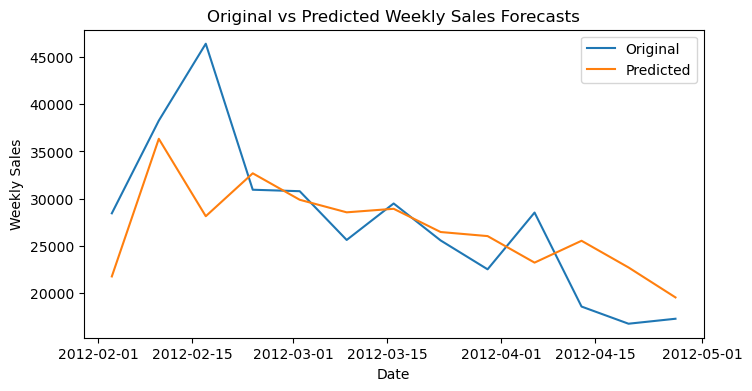

In [132]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_ridge_df, 1, 5)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

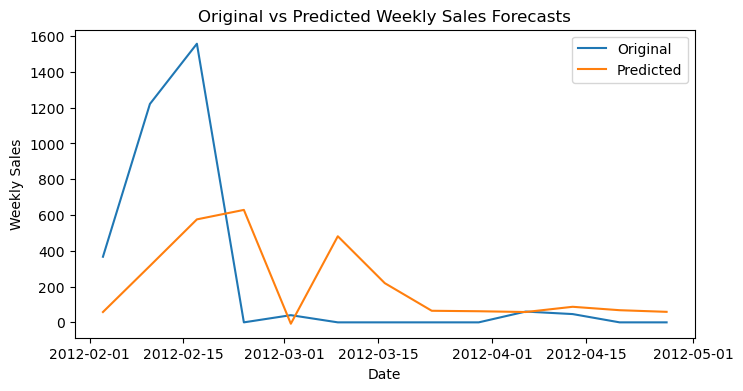

In [133]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_ridge_df, 2, 99)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

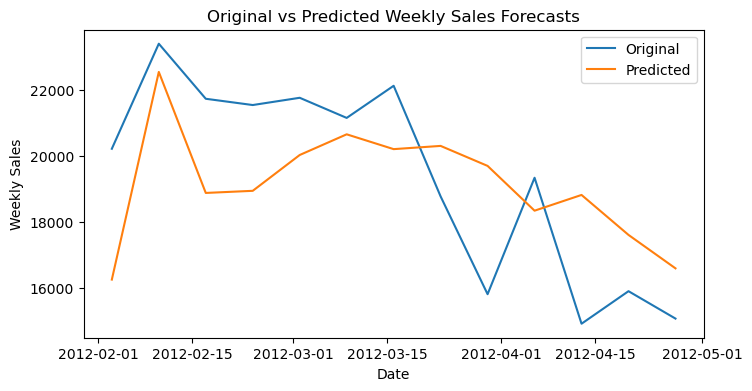

In [134]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_ridge_df, 4, 22)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

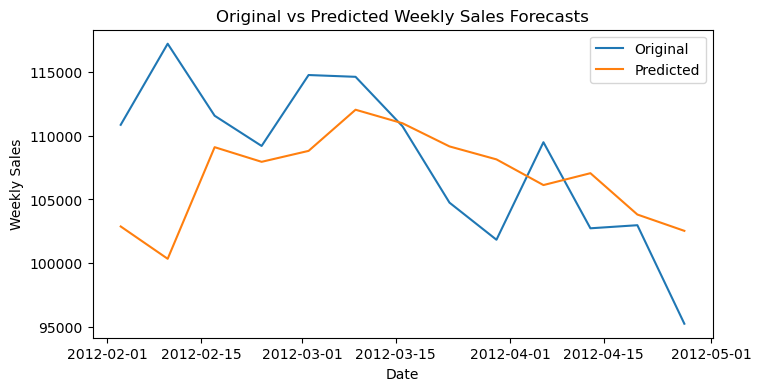

In [135]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_ridge_df, 5, 40)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

#### Random Forest Regressor:

In [136]:
from sklearn.ensemble import RandomForestRegressor
def fit_random_forest_regressor(X_train, y_train, n_estimators, max_depth):
    """
    This function fits random forest regressor model
    """
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)
    
    return model

In [137]:
def train_random_forest_regressor(df, n_estimators, max_depth):
    """
    This function trains every series of the dataframe.
    """
    models_dict = {}
    
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            X_train, y_train, scaler = preprocess_data_for_regression(df_store_dept)
            try:
                model_fit = fit_random_forest_regressor(X_train, y_train, n_estimators, max_depth)
                models_dict[(store_no, dept_no)] = (scaler, model_fit)
            except Exception as e:
                print(f'Failed to fit Random Forest Regressor model for store {store_no}, category {dept_no}: {e}')
    return models_dict

In [138]:
def get_prediction_random_forest_regressor(df, models_dict):
    predicted_random_forest_df = pd.DataFrame()
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            df_store_dept = df_store_dept.sort_values(by='Date')
            date_test = df_store_dept['Date']
            y_test = df_store_dept['Weekly_Sales']
            columns_to_drop = ['Date', 'Weekly_Sales', 'Store', 'Dept']
            X_test = df_store_dept.drop(columns=columns_to_drop)
            X_test = models_dict[(store_no, dept_no)][0].transform(X_test)
            y_val_pred = models_dict[(store_no, dept_no)][1].predict(X_test)
            prediction_df = pd.DataFrame({
                            'Date': date_test,
                            'Weekly_Sales': y_test,
                            'Weekly_Sales_Predicted': y_val_pred})
            prediction_df['Store'] = store_no
            prediction_df['Dept'] = dept_no
            predicted_random_forest_df  = pd.concat([predicted_random_forest_df, prediction_df], ignore_index=False)
    return predicted_random_forest_df

#### Perform Grid Search CV for Random Forest:

In [140]:
# perform grid search cv for random foresr
n_estimators_list = [50, 100, 200]
max_depth_list = [None, 10, 20]

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        random_forest_trained_models_dict = train_random_forest_regressor(df_train, n_estimators, max_depth)
        train_forecasted_random_forest_df = get_prediction_random_forest_regressor(df_train, random_forest_trained_models_dict)
        mape_score_random_forest_train = round(mean_absolute_percentage_error(train_forecasted_random_forest_df), 4)
        validation_forecasted_random_forest_df = get_prediction_random_forest_regressor(df_val, random_forest_trained_models_dict)
        mape_score_random_forest_validation = round(mean_absolute_percentage_error(validation_forecasted_random_forest_df), 4)
        print(f"Model Trained with n_estimators: {n_estimators}, max_depth: {max_depth}")
        print(f"Train Score for Random Forest Regressor is {mape_score_random_forest_train}")
        print(f"Validation Score for Random Forest Regressor is {mape_score_random_forest_validation}")

Model Trained with n_estimators: 50, max_depth: None
Train Score for Random Forest Regressor is 0.5363
Validation Score for Random Forest Regressor is 0.3638
Model Trained with n_estimators: 50, max_depth: 10
Train Score for Random Forest Regressor is 0.4982
Validation Score for Random Forest Regressor is 0.3673
Model Trained with n_estimators: 50, max_depth: 20
Train Score for Random Forest Regressor is 0.5236
Validation Score for Random Forest Regressor is 0.3565
Model Trained with n_estimators: 100, max_depth: None
Train Score for Random Forest Regressor is 0.5062
Validation Score for Random Forest Regressor is 0.3548
Model Trained with n_estimators: 100, max_depth: 10
Train Score for Random Forest Regressor is 0.4728
Validation Score for Random Forest Regressor is 0.3599
Model Trained with n_estimators: 100, max_depth: 20
Train Score for Random Forest Regressor is 0.5316
Validation Score for Random Forest Regressor is 0.3581
Model Trained with n_estimators: 200, max_depth: None
Tra

#### Conclusion:
Best Train Score: 0.4804  <br>
Best Validation Score: 0.3551  <br>
<br>
Best Hyperparameter for Random Forest Model:  <br>
n_estimators : 200 <br>
max_depth: None

In [141]:
# training with best parameters
n_estimators = 200
max_depth = None
random_forest_trained_models_dict = train_random_forest_regressor(df_train_val, n_estimators, max_depth)
train_forecasted_random_forest_df = get_prediction_random_forest_regressor(df_train_val, random_forest_trained_models_dict)
mape_score_random_forest_train = round(mean_absolute_percentage_error(train_forecasted_random_forest_df), 4)
test_forecasted_random_forest_df = get_prediction_random_forest_regressor(df_test, random_forest_trained_models_dict)
mape_score_random_forest_test = round(mean_absolute_percentage_error(test_forecasted_random_forest_df), 4)

print(f"Train Score for Random Forest Regressor is {mape_score_random_forest_train}")
print(f"Test Score for Random Forest Regressor is {mape_score_random_forest_test}")

Train Score for Random Forest Regressor is 0.4301
Test Score for Random Forest Regressor is 2.5865


In [142]:
table.append_row(["Random Forest Regressor", "0.4804", "0.3551", "2.5865"])
print(table)

+-------------------------+------------+-----------------+-----------+
|       Model Name        | Train MAPE | Validation MAPE | Test MAPE |
+-------------------------+------------+-----------------+-----------+
|          ARIMA          |     --     |      0.381      |   4.772   |
+-------------------------+------------+-----------------+-----------+
|         SARIMAX         |     --     |      0.417      |  12.102   |
+-------------------------+------------+-----------------+-----------+
|         PROPHET         |     --     |      0.452      |  23.232   |
+-------------------------+------------+-----------------+-----------+
|      ARIMA+Exogen       |     --     |      0.383      |   4.453   |
+-------------------------+------------+-----------------+-----------+
|     Ridge Regressor     |   8.439    |      0.365      |   2.865   |
+-------------------------+------------+-----------------+-----------+
| Random Forest Regressor |    0.48    |      0.355      |   2.587   |
+-----

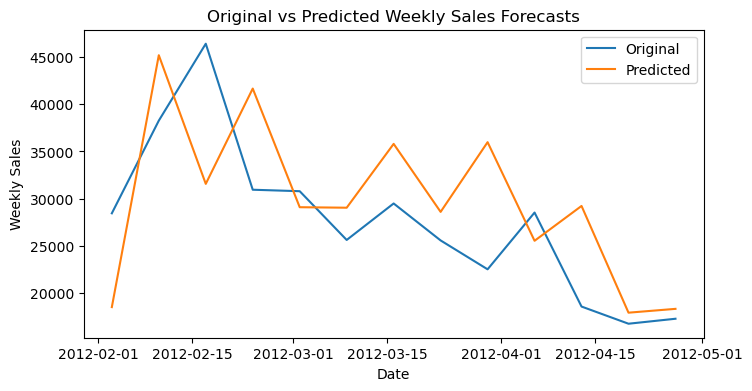

In [143]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_random_forest_df, 1, 5)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

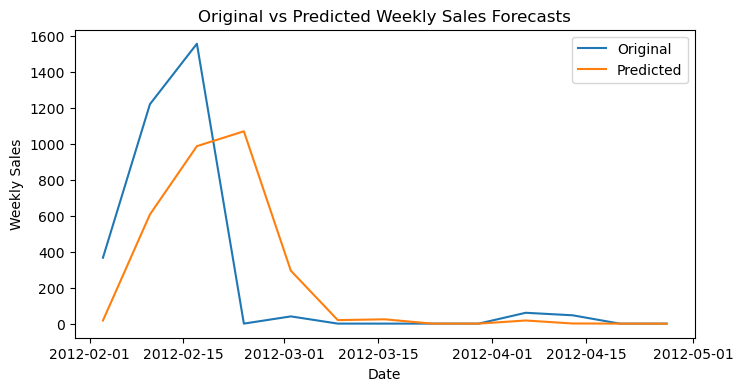

In [144]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_random_forest_df, 2, 99)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

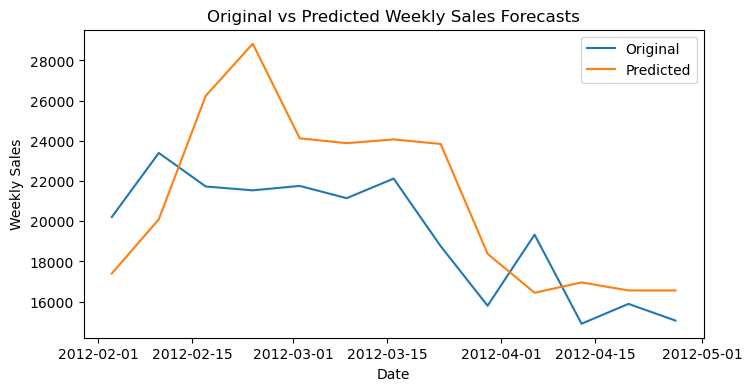

In [145]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_random_forest_df, 4, 22)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

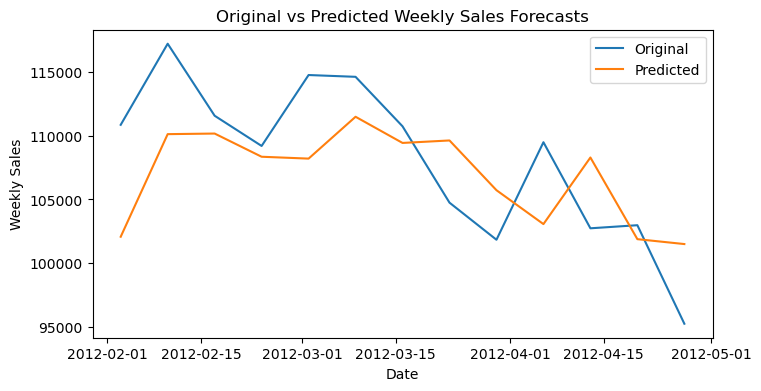

In [146]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_random_forest_df, 5, 40)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

#### Random Forest with Log Transformed Target Variable:

In [192]:
from sklearn.ensemble import RandomForestRegressor
def fit_random_forest_regressor_lt(X_train, y_train, n_estimators, max_depth):
    """
    This function fits random forest regressor model
    """
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)
    
    return model

In [224]:
def train_random_forest_regressor_lt(df, n_estimators, max_depth):
    """
    This function trains every series of the dataframe.
    """
    models_dict = {}
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            X_train, y_train, scaler = preprocess_data_for_regression(df_store_dept)
            # Perform log transformation on the target variable
            # Adding 1 to avoid log(0)
            y_train = np.log(y_train + 1)
            # replacing NaN values with Zero to avoid fitting error in RanDom Forest
            y_train = y_train.fillna(0)
            # replacing -inf and inf values with Zero to avoid fitting error
            y_train = y_train.replace([np.inf, -np.inf], 0)
            try:
                model_fit = fit_random_forest_regressor_lt(X_train, y_train, n_estimators, max_depth)
                models_dict[(store_no, dept_no)] = (scaler, model_fit)
            except Exception as e:
                print(f'Failed to fit Random Forest Regressor model for store {store_no}, category {dept_no}: {e}')
    return models_dict

In [225]:
def get_prediction_random_forest_regressor_lt(df, models_dict):
    predicted_random_forest_df = pd.DataFrame()
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            df_store_dept = df_store_dept.sort_values(by='Date')
            date_test = df_store_dept['Date']
            y_test = df_store_dept['Weekly_Sales']
            columns_to_drop = ['Date', 'Weekly_Sales', 'Store', 'Dept']
            X_test = df_store_dept.drop(columns=columns_to_drop)
            X_test = models_dict[(store_no, dept_no)][0].transform(X_test)
            y_val_pred_log = models_dict[(store_no, dept_no)][1].predict(X_test)
            # Apply the anti-log transformation to predictions
            # Subtracting 1 to revert the initial log transformation
            y_val_pred = np.exp(y_val_pred_log) - 1 
            prediction_df = pd.DataFrame({
                            'Date': date_test,
                            'Weekly_Sales': y_test,
                            'Weekly_Sales_Predicted': y_val_pred})
            prediction_df['Store'] = store_no
            prediction_df['Dept'] = dept_no
            predicted_random_forest_df  = pd.concat([predicted_random_forest_df, prediction_df], ignore_index=False)
    return predicted_random_forest_df

In [229]:
# training with best parameters
n_estimators = 200
max_depth = None
random_forest_lt_trained_models_dict = train_random_forest_regressor_lt(df_train, n_estimators, max_depth)
train_forecasted_random_forest_lt_df = get_prediction_random_forest_regressor_lt(df_val, random_forest_lt_trained_models_dict)
mape_score_random_forest_lt_train = round(mean_absolute_percentage_error(train_forecasted_random_forest_lt_df), 4)
test_forecasted_random_forest_lt_df = get_prediction_random_forest_regressor_lt(df_test, random_forest_lt_trained_models_dict)
mape_score_random_forest_lt_test = round(mean_absolute_percentage_error(test_forecasted_random_forest_lt_df), 4)

print(f"Train Score for Random Forest Regressor is {mape_score_random_forest_lt_train}")
print(f"Validation Score for Random Forest Regressor is {mape_score_random_forest_lt_test}")

Train Score for Random Forest Regressor is 0.2934
Validation Score for Random Forest Regressor is 1.8764


In [230]:
# training with best parameters
n_estimators = 200
max_depth = None
random_forest_lt_trained_models_dict = train_random_forest_regressor_lt(df_train_val, n_estimators, max_depth)
train_forecasted_random_forest_lt_df = get_prediction_random_forest_regressor_lt(df_train_val, random_forest_lt_trained_models_dict)
mape_score_random_forest_lt_train = round(mean_absolute_percentage_error(train_forecasted_random_forest_lt_df), 4)
test_forecasted_random_forest_lt_df = get_prediction_random_forest_regressor_lt(df_test, random_forest_lt_trained_models_dict)
mape_score_random_forest_lt_test = round(mean_absolute_percentage_error(test_forecasted_random_forest_lt_df), 4)

print(f"Train Score for Random Forest Regressor is {mape_score_random_forest_lt_train}")
print(f"Test Score for Random Forest Regressor is {mape_score_random_forest_lt_test}")

Train Score for Random Forest Regressor is 0.0839
Test Score for Random Forest Regressor is 2.107


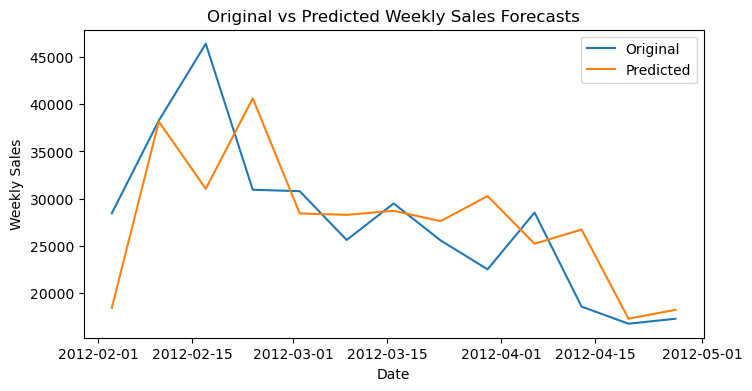

In [231]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_random_forest_lt_df, 1, 5)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

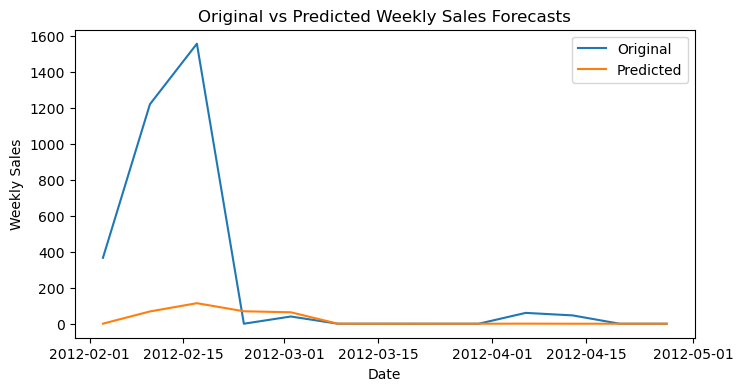

In [232]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_random_forest_lt_df, 2, 99)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

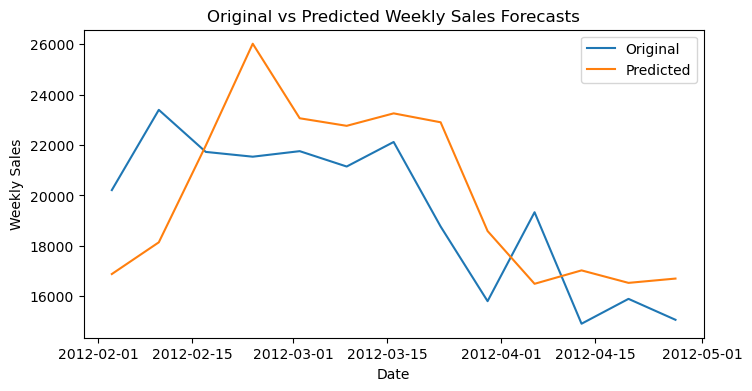

In [233]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_random_forest_lt_df, 4, 22)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

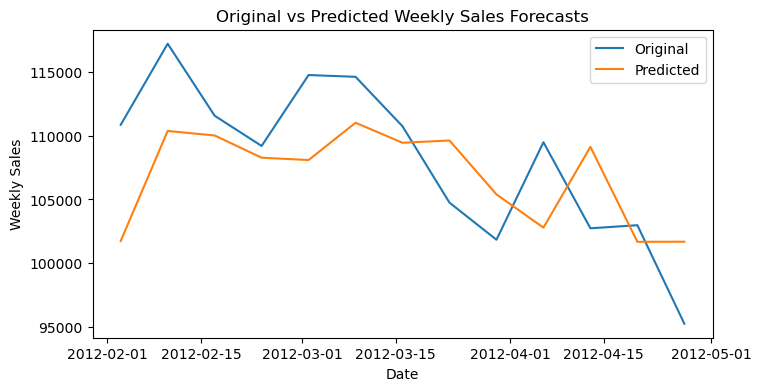

In [234]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_random_forest_lt_df, 5, 40)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

In [235]:
table.append_row(["Random Forest Regressor Log Transformed", "0.2934", "1.8764", "1.8764"])
print(table)

+-----------------------------------+------------+-----------------+-----------+
|            Model Name             | Train MAPE | Validation MAPE | Test MAPE |
+-----------------------------------+------------+-----------------+-----------+
|               ARIMA               |     --     |      0.381      |   4.772   |
+-----------------------------------+------------+-----------------+-----------+
|              SARIMAX              |     --     |      0.417      |  12.102   |
+-----------------------------------+------------+-----------------+-----------+
|              PROPHET              |     --     |      0.452      |  23.232   |
+-----------------------------------+------------+-----------------+-----------+
|           ARIMA+Exogen            |     --     |      0.383      |   4.453   |
+-----------------------------------+------------+-----------------+-----------+
|          Ridge Regressor          |   8.439    |      0.365      |   2.865   |
+---------------------------

## Conclusion:
Random Forest Regressor with Lag and Rolling Window features and Random Forest Regressor with Log-Transformed Target Variable both worked well. Even though Test MAPE of Random Forest Regressor with Log-Transformed Target Variable is lesser, I will pick Random Forest Regressor as the best model because Validation MAPE is comparatively high for Random Forest Regressor with Log-Transformed Target Variable model. On the other hand in case of Random Forest Regressor, all the train, validation and test MAPE scores are at lower side.

## Note:
It is only possible to forecast next week from the regressor models becasue we are using lag features i.e. previous week and also previous month data for the next week prediction. To forecast more number of future week we have to use ARIMA, SARIMAX, PROPHET models. <br>
There is a way to forecast more than a week using regressor models as well, called LeapFrog technique. In this approach the next to next week will be forecasted based on the next week forecast. I am not going to implement this here.